## Imports

In [12]:
import os 
import shutil
from matplotlib import pyplot as plt
import numpy as np
import tqdm
import SimpleITK as sitk
from mpl_toolkits.mplot3d import Axes3D
import scipy
import scipy.signal
import matplotlib
import keras
from scipy import ndimage
from sklearn import metrics
import re

## Data folder

In [13]:
root_dir = '/projects/0/ismi2018/FINALPROJECTS/BREAST_THOMOSYNTHESIS/'
example_img = "/projects/0/ismi2018/FINALPROJECTS/BREAST_THOMOSYNTHESIS/dataset/t0200012302cl/1.dcm"

raw_img = sitk.ReadImage(example_img)

## Read in files

In [72]:
def listCaseIDs(dataRoot):
    cases = [f.replace(".gtrt","") for f in os.listdir(join(dataRoot,"gtrs")) if ".gtrt" in f]
    return cases

def get_file_list(path, ext=''):
    return sorted([os.path.join(path, f) for f in os.listdir(path) if f.endswith(ext)])

def load_img(path):
    return np.array(Image.open(path))

def getPoints(filename,dataRoot):
    annotation = open(filename,"r").read()
    regex = "\[\n[\d* \d* \d*\n+]+"
    prog = re.compile(regex)
    result = prog.findall(annotation)
    
    result = [item for r in result for item in r.split("\n")[1:]]
    result = [[int(c) for c in cords.split()] for cords in result if len(cords.split()) == 3]
    result = np.asarray(result)
    return result

def makeMask(caseID,dataRoot,dims=None):
    anotationFileName = os.path.join(dataRoot,"gtrs",caseID+".gtrt")
    points = getPoints(anotationFileName,dataRoot)
    if(dims is None):
        dims = np.max(points,axis=0) + 1
    Mask = np.zeros(dims)
    print("Points: ", points)
    Mask[points[:,1],points[:,2],points[:,2]] = 1.0
    return Mask

def loadScan(caseID,dataRoot):
    dataFolder = os.path.join(dataRoot,"dataset","t" + caseID)
    images = [f for f in os.listdir(dataFolder) if ".dcm" in f]
    images.sort(key=lambda x: float(x.replace(".dcm","")))
    
    scan = np.zeros(getDims(caseID,dataRoot))
    for i,f in enumerate(images):
        image = sitk.ReadImage ( os.path.join(dataFolder,f) )
        scan[:,:,i] = sitk.GetArrayFromImage(image)
    return scan

def getDims(caseID,dataRoot):
    dataFolder = os.path.join(dataRoot,"dataset","t" + caseID)
    images = [f for f in os.listdir(dataFolder) if ".dcm" in f]
    image = sitk.ReadImage ( os.path.join(dataFolder,images[0]) )
    dims = image.GetSize()
    dims = (dims[1],dims[0],len(images))
    return dims

In [73]:
caseID = "0200710601cl"
scan = loadScan(caseID,root_dir)
mask = makeMask(caseID,root_dir,dims=scan.shape)
print(scan.shape)
print(mask.shape)



Points:  [[ 676 1539   21]
 [ 675 1540   21]
 [ 674 1540   21]
 [ 673 1541   21]
 [ 672 1541   21]
 [ 671 1542   21]
 [ 670 1542   21]
 [ 669 1543   21]
 [ 668 1543   21]
 [ 667 1544   21]
 [ 666 1545   21]
 [ 666 1546   21]
 [ 666 1547   21]
 [ 666 1548   21]
 [ 666 1549   21]
 [ 666 1550   21]
 [ 666 1551   21]
 [ 666 1552   21]
 [ 666 1553   21]
 [ 666 1554   21]
 [ 666 1555   21]
 [ 666 1556   21]
 [ 666 1557   21]
 [ 666 1558   21]
 [ 666 1559   21]
 [ 666 1560   21]
 [ 666 1561   21]
 [ 666 1562   21]
 [ 666 1563   21]
 [ 666 1564   21]
 [ 666 1565   21]
 [ 666 1566   21]
 [ 666 1567   21]
 [ 666 1568   21]
 [ 666 1569   21]
 [ 666 1570   21]
 [ 666 1571   21]
 [ 666 1572   21]
 [ 666 1573   21]
 [ 665 1574   21]
 [ 664 1574   21]
 [ 663 1575   21]
 [ 663 1576   21]
 [ 663 1577   21]
 [ 663 1578   21]
 [ 663 1579   21]
 [ 663 1580   21]
 [ 663 1581   21]
 [ 664 1582   21]
 [ 664 1583   21]
 [ 665 1584   21]
 [ 665 1585   21]
 [ 666 1586   21]
 [ 666 1587   21]
 [ 667 1588   21]
 

In [ ]:
check_list = [1]

[x for x in mask if x.all()  in check_list ]

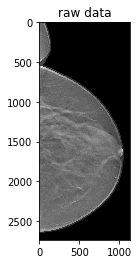

In [74]:
raw_np = scan
plt.imshow(raw_np[:,:,21], cmap='gray')
plt.title('raw data')
plt.show()

# Filters

In [75]:
def gaussian_kernel_2d(sigma, x0=0, y0=0, size_sigma=3):
    '''
        Computes a 2D Gaussian kernel with a given sigma (in pixels), centered at x0, y0
        The size of the kernel can be set as a multiple of the sigma
    '''
    # >>> YOUR CODE STARTS HERE <<<
    g = np.zeros(((2 * sigma * size_sigma + 1),(2 * sigma * size_sigma + 1)))
    
    
    
    for i in range(2 * sigma * size_sigma + 1):
        for j in range(2 * sigma * size_sigma + 1):
            x = i - size_sigma * sigma 
            y = j - size_sigma * sigma 
            g[i,j] = (1/ 2 * np.pi * sigma*sigma) * np.exp(-1*(x*x+y*y)/(2*sigma*sigma))
            
    # >>> YOUR CODE ENDS HERE <<<  

    return g

In [91]:
def extract_features(img):
    """
        Computes features from a give input image.
        returns a Python list of feature maps (numpy arrays, the same size as the image)
        that contain the result of the convolution of each filter with the input image.
        
        As mentioned in the lecture, given the input image 'img', only the green channel
        is typically used in retina fundus image analysis. Therefore, the green channel
        is extracted, and you can use it as input for all subsequent steps in this function.
    """    
    
    img_green = img[:,:,0]
    
    filter_output = np.full_like(img_green, 0)
    
    features = []

    sigma = 4

    ## gaussian laplace, aka Mexican hat
    pixels = ndimage.gaussian_laplace(img_green, sigma, output=None, mode='reflect', cval=0.0)
    features.append(pixels)


    ## zscore
    zscores = scipy.stats.zscore(img_green, axis=None)
    features.append(zscores)
    
    
    ## median
#median_image = scipy.ndimage.median_filter(raw_np, 3)
 #   features.append(median_image)
        
    print(len(features))
    return features

2


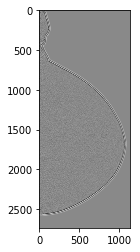

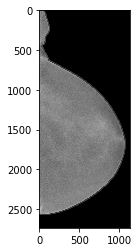

In [92]:

features = extract_features(raw_np)
matplotlib.rcParams['figure.figsize'] = (4, 4)
for f in features:
    plt.imshow(f, cmap='gray')
    plt.show()

## Filter Evaluation

In [93]:
def evaluate_filter(filtered_image, mask, visualize=False):
   
    #Pad the mask, to corresponds with te filtered image shape
    padded_mask = np.zeros(filtered_image.shape)
    padded_mask[:mask.shape[0],:mask.shape[1]] = mask
    print(padded_mask.shape)
    print(filtered_image.shape)
    
    # Compute the roc curve and the area under the curve
    fpr, tpr, thresholds_roc = metrics.roc_curve(np.reshape(padded_mask,-1),np.reshape(filtered_image, -1))
    auc = metrics.auc(fpr, tpr)
    
    # Compute the precision and recall and average precision score
    print(np.reshape(padded_mask, -1))
    print(np.reshape(filtered_image,-1))
    
    precision, recall, thresholds_pr = metrics.precision_recall_curve(np.reshape(padded_mask, -1), np.reshape(filtered_image,-1))
    average_precision = metrics.average_precision_score(padded_mask,filtered_image)
    
    #Get the best threshold, recall > 0.95 and best precision
    recall_indices = np.where(recall > 0.95)
    print(recall)
    index = np.argmax(precision[recall_indices])
    best_index = recall_indices[index]
    best_threshold = thresholds_pr[best_index]
    
    if(visualize):
        #plot roc curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange',
                 label='ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
        plt.legend(loc="lower right")
        plt.show()

        #plot precision recall curve
        plt.step(recall, precision, color='b', alpha=0.2, where='post')
        plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
        
        
    return best_threshold

(2736, 1134)
(2736, 1134)
[ 0.  0.  0. ...,  0.  0.  0.]
[ 14.62789764  14.0680016   12.96220887 ...,   0.           0.           0.        ]


/home/ruc0033/.local/lib/python3.6/site-packages/sklearn/metrics/ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


[ 1.          0.98275862  0.98275862 ...,  0.          0.          0.        ]


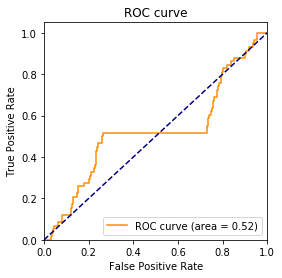

array([-3.15956736, -3.15956566, -3.15955697, ..., -2.78101301,
       -2.78099582, -2.78099353])

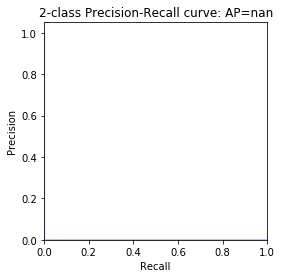

In [94]:
# Check for mexican hat
evaluate_filter(features[0], mask[:,:,21], visualize=True)

(2736, 1134)
(2736, 1134)
[ 0.  0.  0. ...,  0.  0.  0.]
[ 0.7890384   0.88288217  0.94959039 ..., -1.02678194 -1.02678194
 -1.02678194]


/home/ruc0033/.local/lib/python3.6/site-packages/sklearn/metrics/ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


[ 1.          0.98275862  0.98275862 ...,  0.          0.          0.        ]


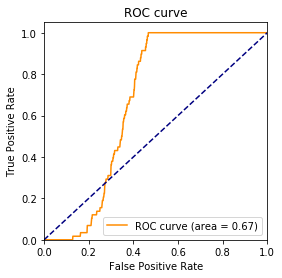

array([ 0.74946573,  0.75059638,  0.75172703,  0.75285767,  0.75398832,
        0.75511897,  0.75624962,  0.75738027,  0.75851091,  0.75964156,
        0.76077221,  0.76190286,  0.7630335 ,  0.76416415,  0.7652948 ])

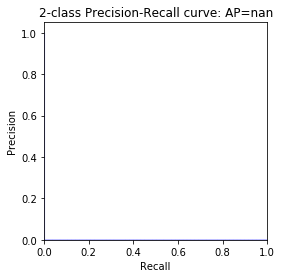

In [87]:
# check for z score
evaluate_filter(features[1], mask[:,:,21], visualize=True)